In [1]:
import plotly.express as px
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import glob

import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

In [2]:
seg = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/untuned_singletask_oracle/162935/singletask_seg_all.npy')
# (256, 103, 256, 256)

# load in dataframe of bboxes
mri_id = 162935

dicto = {}
for label in range(1, 103):
    df_boxes = pd.read_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/{label}/0.1/isolated_path_df_SAM_bboxes_from_ground_truth.csv')

    df_boxes = df_boxes[df_boxes['id'] == mri_id].reset_index(drop=True)
    df_boxes['label'] = label
    dicto[label] = df_boxes

In [3]:
dfo = dicto[1]
coords_df = dfo[dfo['slice'] == 140][['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3']]
coords_np = np.array(coords_df).ravel()
#coords_list = coords_np.tolist()
#(x1, y1, x2, y2) = coords_np



In [51]:
def plot_for_label(label, slice, seg_arr, axs, zoom_img = False, include_bbox=True):
    

    dfo = dicto[label]
    if slice is None:
        # pick the slice using dfo median of the slices that actually have bboxes
        dfo_no_na = dfo[pd.isna(dfo['bbox_0']) == False].reset_index(drop=True)
        dfo_no_na['area'] = (dfo_no_na['bbox_2'] - dfo_no_na['bbox_0']) * (dfo_no_na['bbox_3'] - dfo_no_na['bbox_1'])
        slice = dfo_no_na[dfo_no_na['area'] == dfo_no_na['area'].max()].reset_index(drop=True).loc[0, 'slice']
        #slice = int(dfo[pd.isna(dfo['bbox_0']) == False]['slice'].median())
        print(slice)
        print(f'max area {dfo_no_na["area"].max()}')

    # show the MRI slice
    path = f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/dir_structure_for_yolov7/test/images/{mri_id}_slice{slice}.png'
    img = Image.open(path)
    img = np.array(img)
    # rotate 90
    img = np.rot90(img, 3)
    # horizontally flip
    img = np.flip(img, axis=1)
    axs.imshow(img)

    # overlay the segmentation
    if seg_arr.shape == (256, 103, 256, 256):
        seg_arr = seg_arr[slice, label, :, :]
    elif seg_arr.shape == (103, 256, 256):
        seg_arr = seg_arr[label, :, :]
    else:
        assert False
    seg_arr = np.rot90(seg_arr, 3)
    # horizontally flip
    seg_arr = np.flip(seg_arr, axis=1)
    show_mask(seg_arr, axs, random_color=False)

    # overlay the bounding box
    
    coords_df = dfo[dfo['slice'] == slice][['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3']]
    coords_np = np.array(coords_df).ravel()
    coords_np[0], coords_np[1] = coords_np[1], coords_np[0]
    coords_np[2], coords_np[3] = coords_np[3], coords_np[2]
    if include_bbox:    
        show_box(coords_np, axs, color = 'blue')

    if zoom_img:
        # get xlim and ylim based on the bounding box coordinates
        x1 = coords_np[0]
        y1 = coords_np[1]
        x2 = coords_np[2]
        y2 = coords_np[3]
        xlim = [x1, x2]
        ylim = [y1, y2]
        

        # expand lims so they form the minimum size square
        if xlim[1] - xlim[0] >= ylim[1] - ylim[0]:
            diff = (xlim[1] - xlim[0]) - (ylim[1] - ylim[0])
            ylim[0] -= diff // 2
            ylim[1] += diff // 2
        else:
            diff = (ylim[1] - ylim[0]) - (xlim[1] - xlim[0])
            xlim[0] -= diff // 2
            xlim[1] += diff // 2

        # then expand by 5 pixels on each side
        num_expand = 40
        xlim[0] -= num_expand
        xlim[1] += num_expand
        ylim[0] -= num_expand
        ylim[1] += num_expand

        # ensure all the xlim and ylim are between 0 and 256 inclusive
        xlim[0] = max(0, xlim[0])
        xlim[1] = min(256, xlim[1])
        ylim[0] = max(0, ylim[0])
        ylim[1] = min(256, ylim[1])

        axs.set_xlim(xlim)
        axs.set_ylim(ylim)

    return slice

139
max area 10752.0
143
max area 2900.0
160
max area 108.0
174
max area 1872.0
179
max area 3717.0
141
max area 884.0
130
max area 735.0
147
max area 760.0
149
max area 360.0
142
max area 125.0
174
max area 252.0
173
max area 1092.0
159
max area 450.0
163
max area 220.0
142
max area 312.0
151
max area 160.0
154
max area 744.0
153
max area 104.0
142
max area 2295.0
140
max area 10624.0
140
max area 2403.0
168
max area 36.0
174
max area 1960.0
180
max area 3248.0
139
max area 825.0
131
max area 600.0
151
max area 770.0
146
max area 391.0
156
max area 528.0
162
max area 189.0
151
max area 187.0
152
max area 810.0
154
max area 36.0
139
max area 2349.0
160
max area 60.0
127
max area 75.0
125
max area 70.0
124
max area 56.0
129
max area 52.0
142
max area 76.0
121
max area 352.0
106
max area 1152.0
133
max area 920.0
173
max area 468.0
163
max area 2130.0
126
max area 1302.0
171
max area 1170.0
118
max area 378.0
148
max area 2156.0
161
max area 1682.0
150
max area 1800.0
157
max area 1827.0

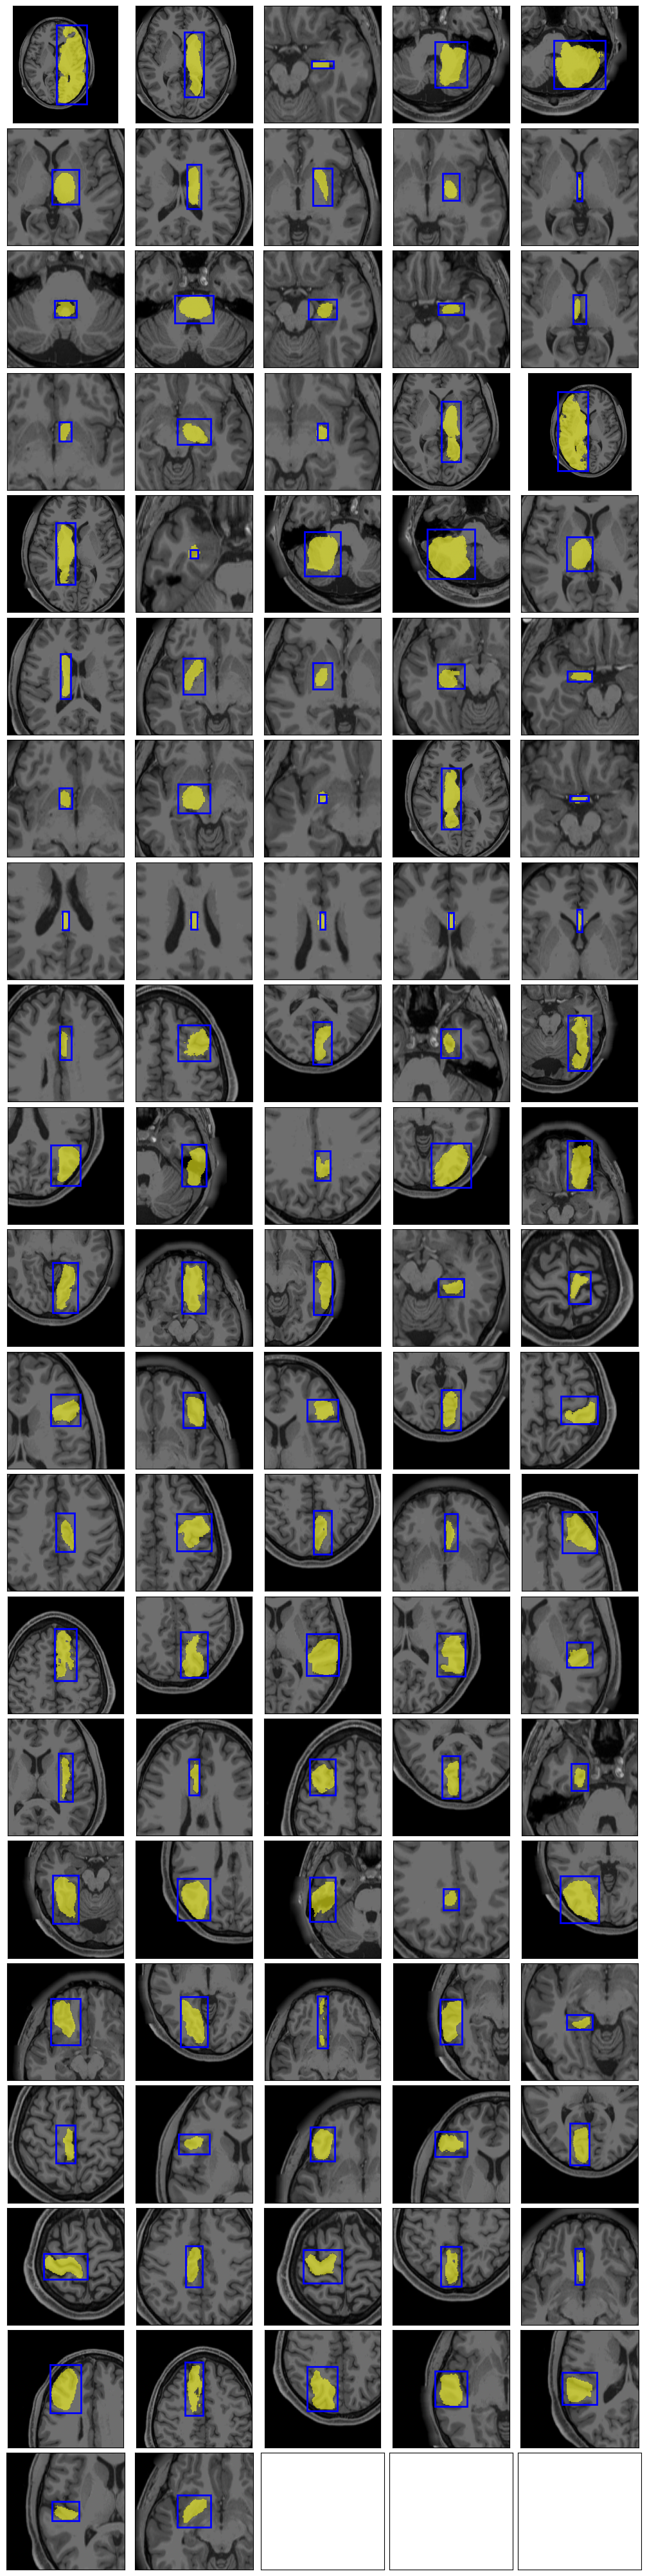

In [48]:
r=21
c=5
fig, axs = plt.subplots(r,c, squeeze=False, figsize=(10,40), constrained_layout=True)
idx = 1
for label in range(1, min(r*c, 103)):
    i = (label-1) // c
    j = (label-1) % c
    plot_for_label(label, None, seg, axs[i,j], True)

for i in range(r):
    for j in range(c):
        axs[i,j].grid(False)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([]) 

In [6]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
dir(label_converter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'comp_to_hcp_d',
 'comp_to_name_d',
 'compressed_to_hcp',
 'compressed_to_name',
 'hcp_to_comp_d',
 'hcp_to_compressed',
 'hcp_to_name',
 'hcp_to_name_d',
 'lookup_table',
 'name_to_comp_d',
 'name_to_compressed']

In [7]:
zy = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/class_counts/class_counts_per_slice.csv')
zy = zy[zy['id'] == mri_id].reset_index(drop=True)
bst_slice = {}
for lab in range(1, 103):
    bst_slice[lab] = zy.sort_values(f'label{lab}', ascending=False).reset_index(drop=True).loc[0,'slice']

bst_slice[2] = 129

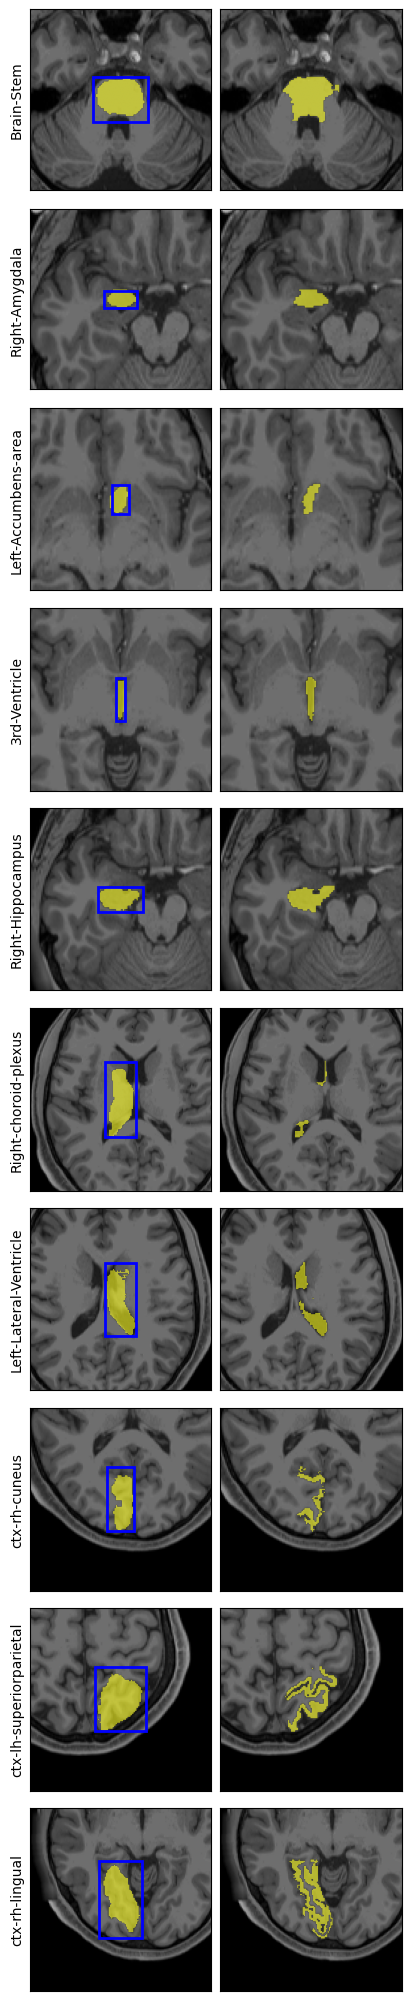

In [52]:
# best and worst by untuned accuracy comparison plot

best_labels = ['Brain-Stem', 'Right-Amygdala', 'Left-Accumbens-area', '3rd-Ventricle', 'Right-Hippocampus']
worst_labels = ['Right-choroid-plexus', 'Left-Lateral-Ventricle', 'ctx-rh-cuneus', 'ctx-lh-superiorparietal', 'ctx-rh-lingual']
labels_of_interest_txt = best_labels + worst_labels
labels_of_interest = [label_converter.name_to_compressed(x).item() for x in labels_of_interest_txt]

r=len(labels_of_interest)
c=2
fig, axs = plt.subplots(r,c, squeeze=False, figsize=(4,20), constrained_layout=True)
#slices = [173, 162, 151, 142, 156, 133, 143, 134, 112, 148]
slices = [bst_slice[x] for x in labels_of_interest]
for i, label in enumerate(labels_of_interest):
    slice = plot_for_label(label, slices[i], seg, axs[i,0], True)
    gt_seg = np.load(f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/{mri_id}/seg_{slice}.npy') # (256,256)
    
    gt_seg = label_converter.hcp_to_compressed(gt_seg) # (256,256)

    # one-hot encode to (103, 256, 256)
    one_hot_enc = np.zeros((103,256*256))

    gt_flattened = gt_seg.flatten() # 256*256
    one_hot_enc[gt_flattened, np.arange(len(gt_flattened))] = 1 # (103, 256*256)
    one_hot_enc = np.reshape(one_hot_enc, (103,256,256))

    plot_for_label(label, slice, one_hot_enc, axs[i,1], True, include_bbox=False)

    label_txt = labels_of_interest_txt[i]
    axs[i,0].set_ylabel(label_txt)
for i in range(r):
    for j in range(2):
        axs[i,j].grid(False)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([]) 

fig.savefig(f'/gpfs/home/kn2347/figs/untuned_segmentations/best_and_worst.pdf')

In [54]:
np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_oracle/162935/singletask_seg_all.npy').shape

(256, 103, 256, 256)

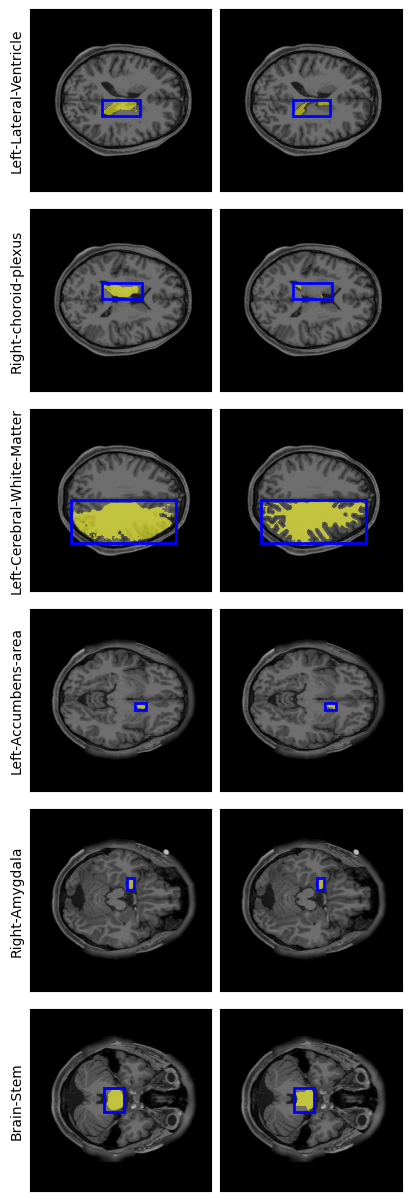

In [58]:
# most change between untuned and finetuned comparison plot
least_labels = ['Left-Accumbens-area', 'Right-Amygdala', 'Brain-Stem']
most_labels = ['Left-Lateral-Ventricle', 'Right-choroid-plexus', 'Left-Cerebral-White-Matter']
labels_of_interest_txt = most_labels + least_labels
labels_of_interest = [label_converter.name_to_compressed(x).item() for x in labels_of_interest_txt]

r=len(labels_of_interest)
c=2
fig, axs = plt.subplots(r,c, squeeze=False, figsize=(4,12), constrained_layout=True)
#slices = [173, 162, 151, 142, 156, 133, 143, 134, 112, 148]
slices = [bst_slice[x] for x in labels_of_interest]
for i, label in enumerate(labels_of_interest):
    slice = plot_for_label(label, slices[i], seg, axs[i,0])

    seg_medsam_oracle = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_oracle/162935/singletask_seg_all.npy')
    # ^ this is (256, 103, 256, 256)
    plot_for_label(label, slices[i], seg_medsam_oracle, axs[i,1])

    label_txt = labels_of_interest_txt[i]
    axs[i,0].set_ylabel(label_txt)
for i in range(r):
    for j in range(2):
        axs[i,j].grid(False)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([]) 

fig.savefig(f'/gpfs/home/kn2347/figs/untuned_segmentations/most_delta_untuned_to_finetuned.pdf')

139
max area 10752.0
143
max area 2900.0
160
max area 108.0
174
max area 1872.0
179
max area 3717.0
141
max area 884.0
130
max area 735.0
147
max area 760.0
149
max area 360.0
142
max area 125.0
174
max area 252.0
173
max area 1092.0
159
max area 450.0
163
max area 220.0
142
max area 312.0
151
max area 160.0
154
max area 744.0
153
max area 104.0
142
max area 2295.0
140
max area 10624.0
140
max area 2403.0
168
max area 36.0
174
max area 1960.0
180
max area 3248.0
139
max area 825.0
131
max area 600.0
151
max area 770.0
146
max area 391.0
156
max area 528.0
162
max area 189.0
151
max area 187.0
152
max area 810.0
154
max area 36.0
139
max area 2349.0
160
max area 60.0
127
max area 75.0
125
max area 70.0
124
max area 56.0
129
max area 52.0
142
max area 76.0
121
max area 352.0
106
max area 1152.0
133
max area 920.0
173
max area 468.0
163
max area 2130.0
126
max area 1302.0
171
max area 1170.0
118
max area 378.0
148
max area 2156.0
161
max area 1682.0
150
max area 1800.0
157
max area 1827.0

/tmp/ipykernel_802492/3767265544.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(r,c, squeeze=False, figsize=(4,10), constrained_layout=True)


136
max area 408.0
154
max area 930.0


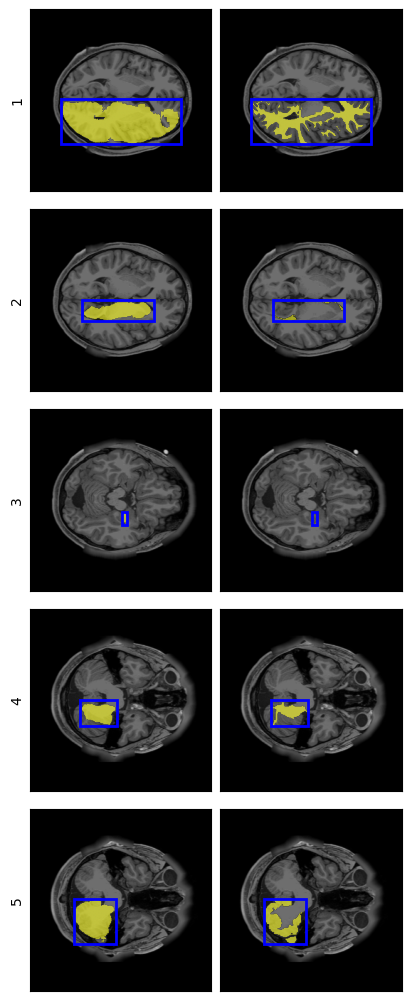

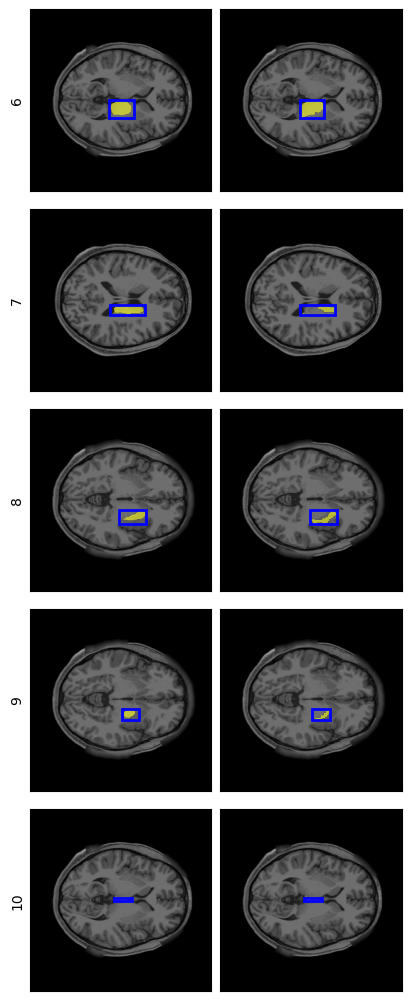

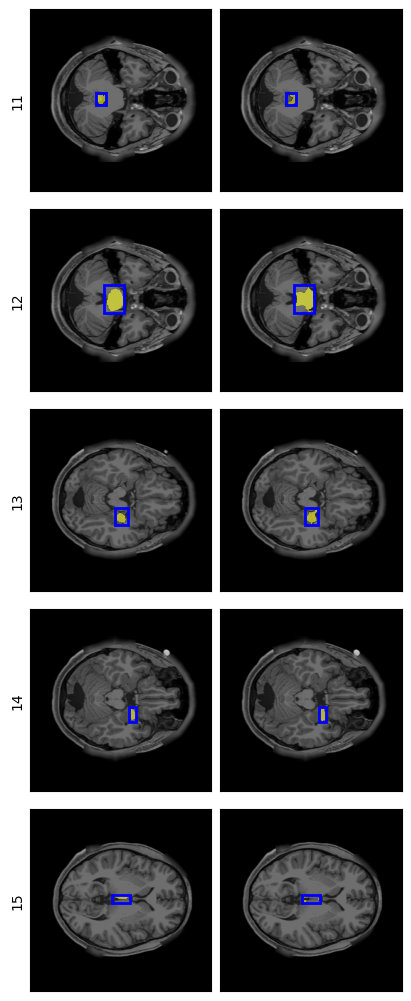

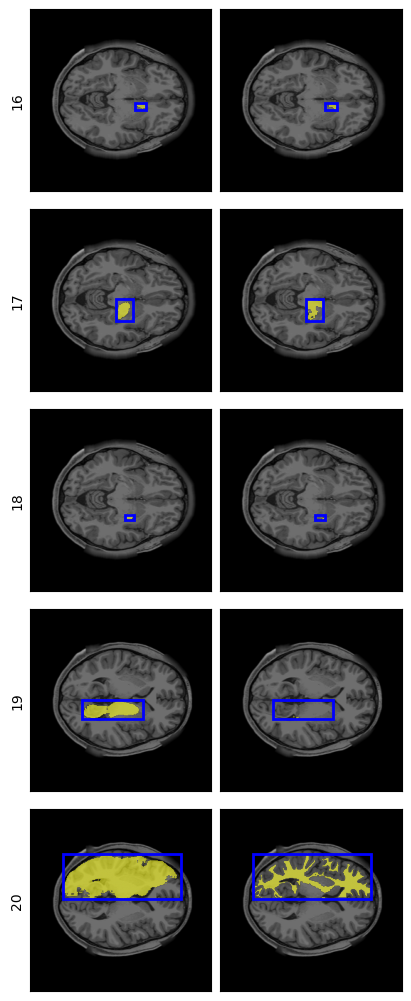

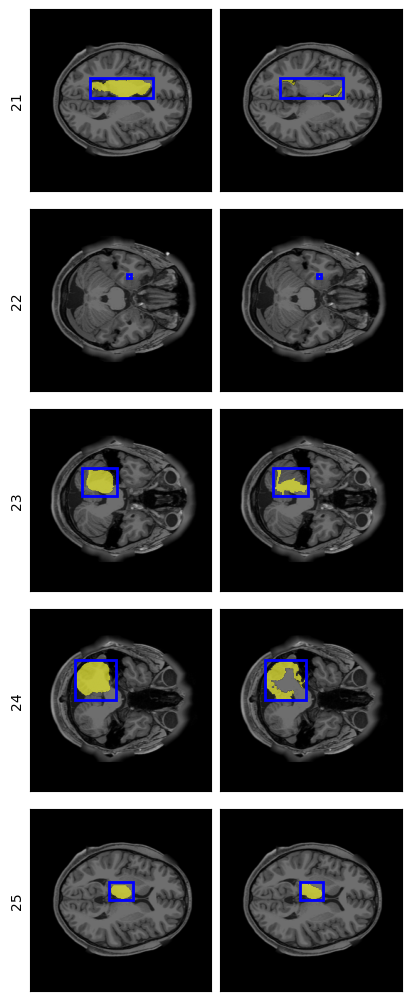

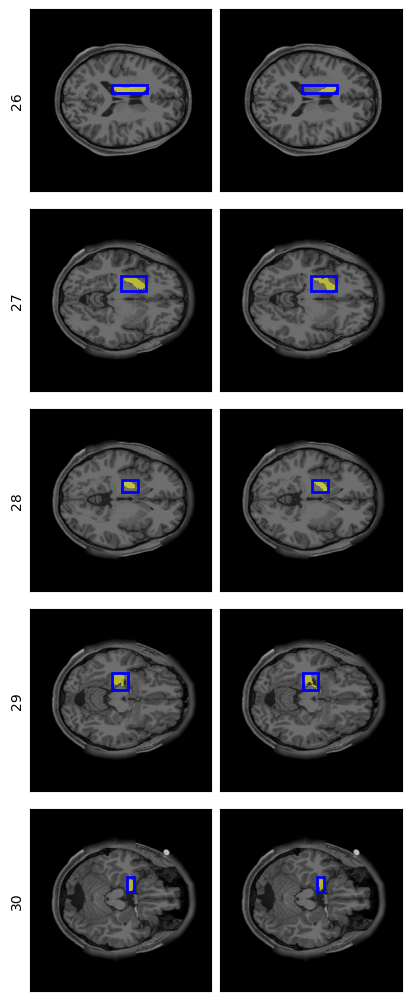

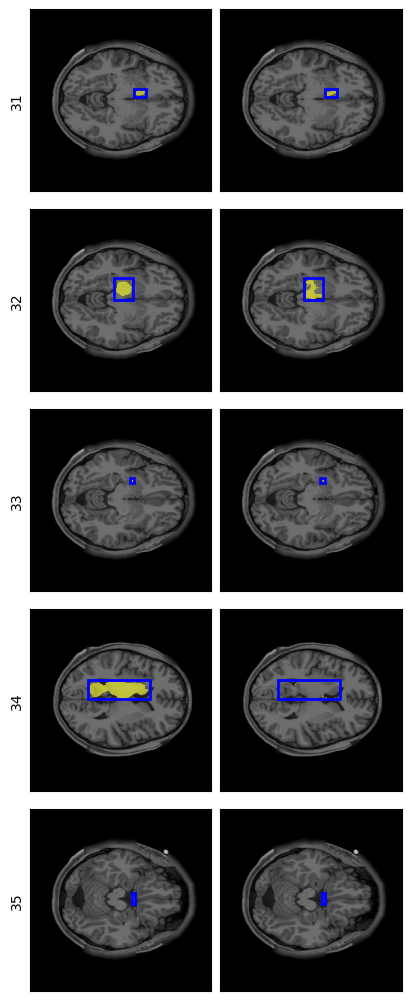

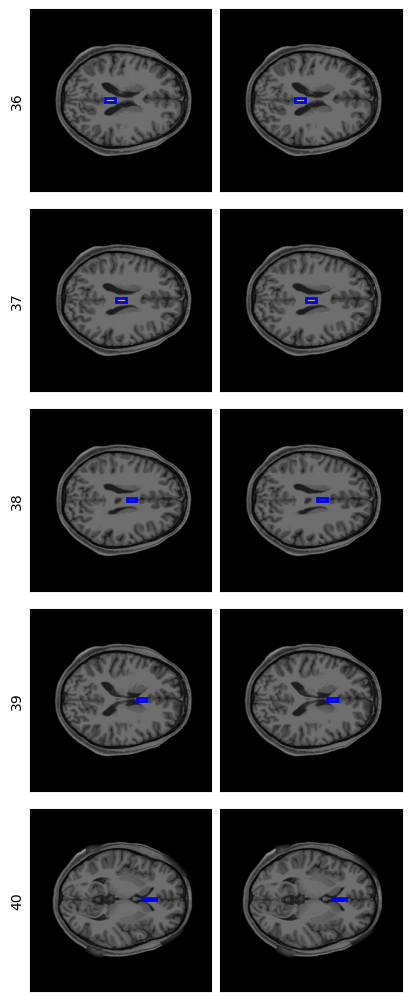

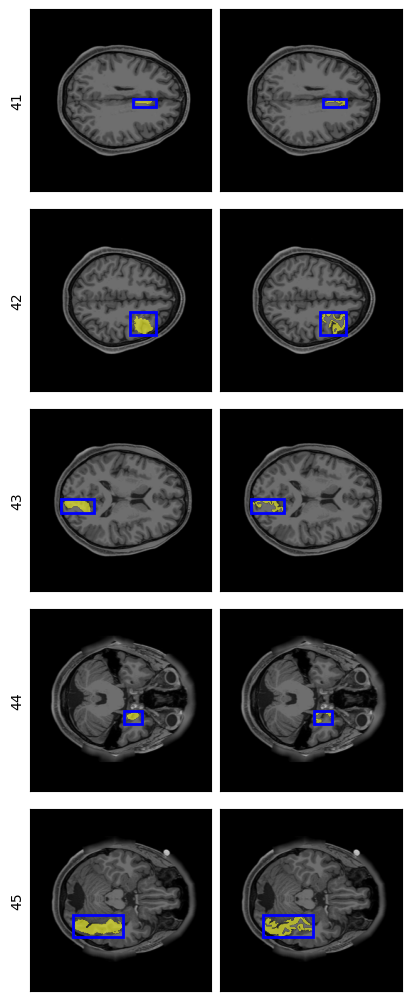

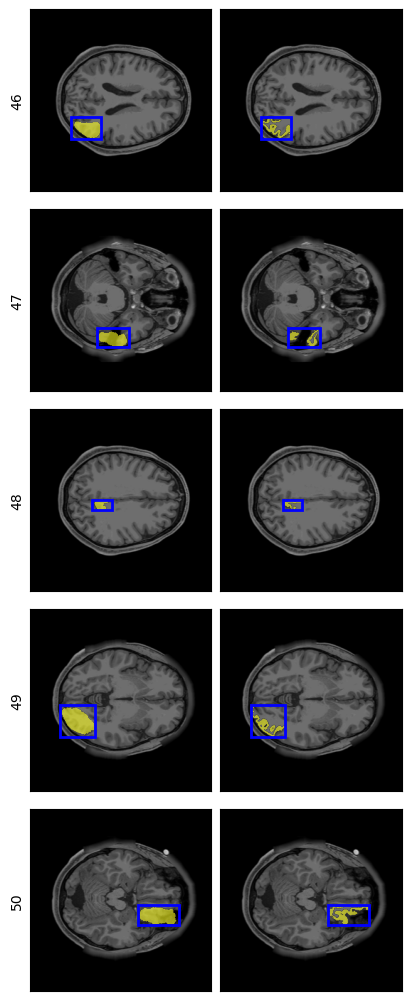

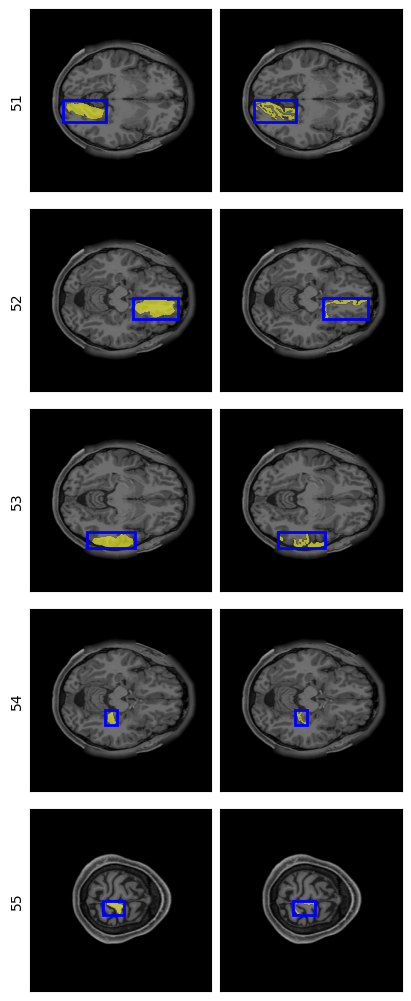

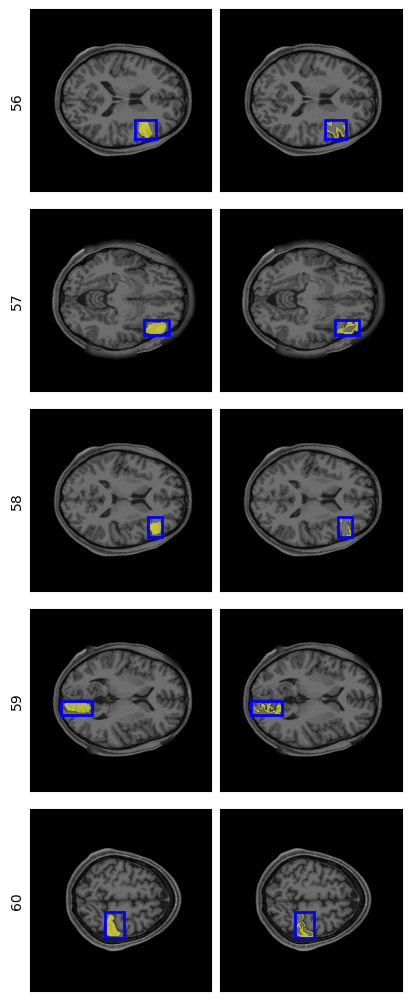

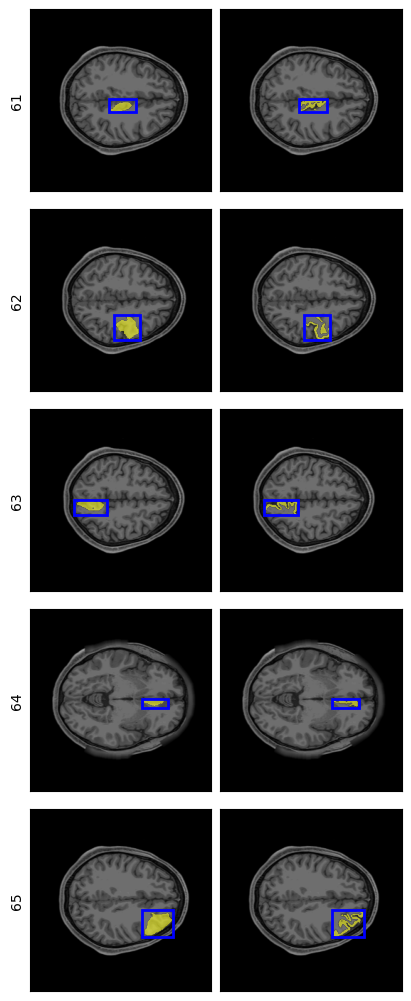

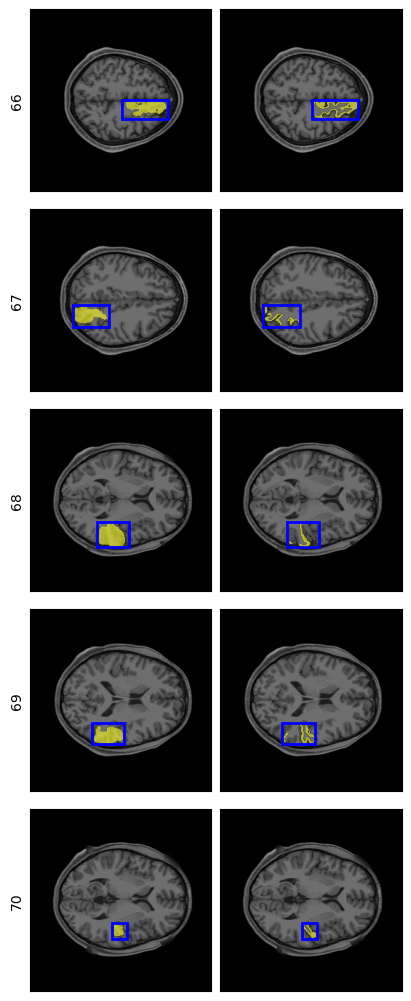

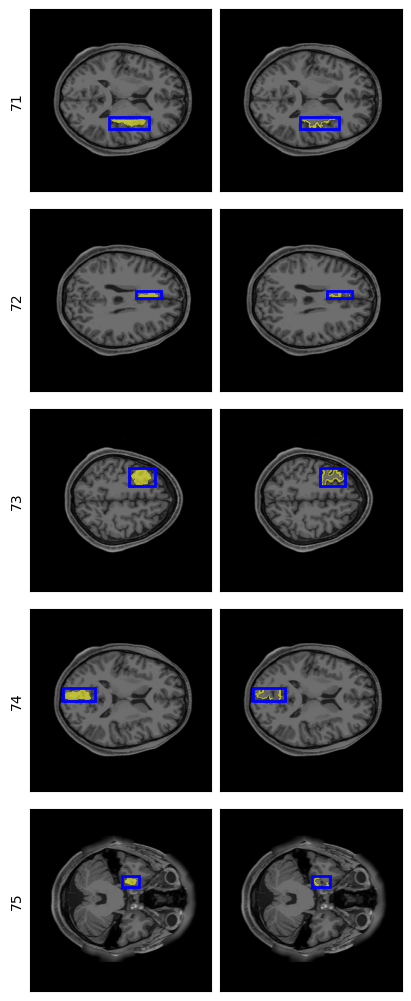

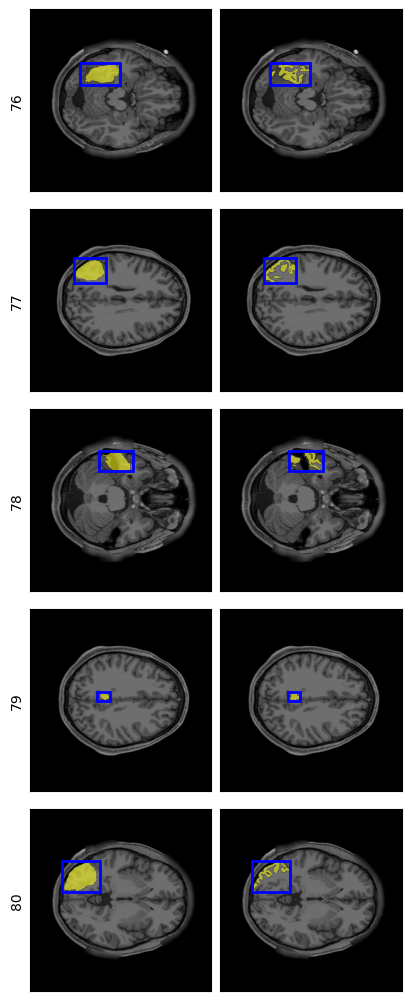

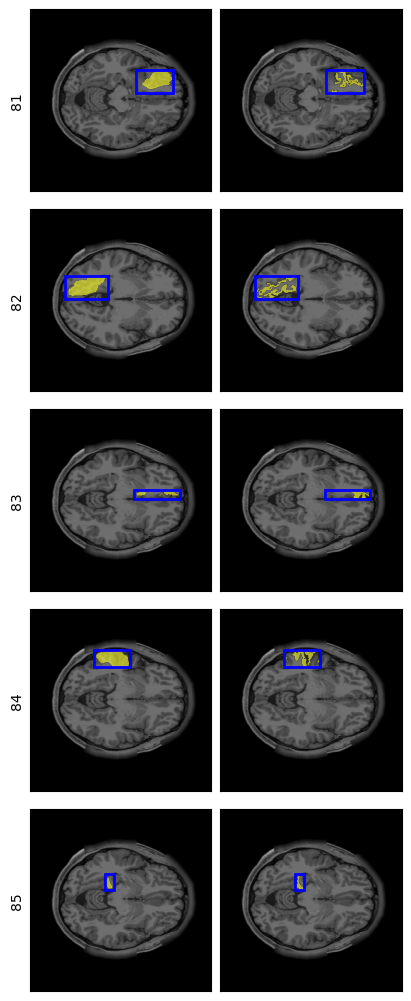

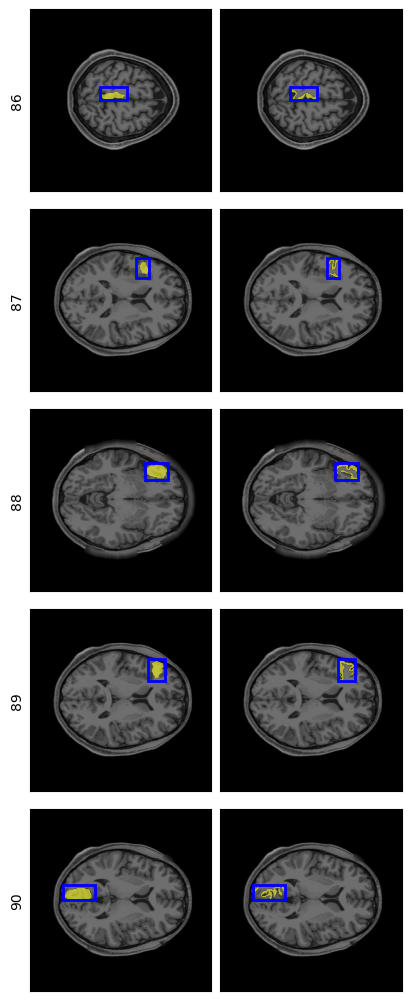

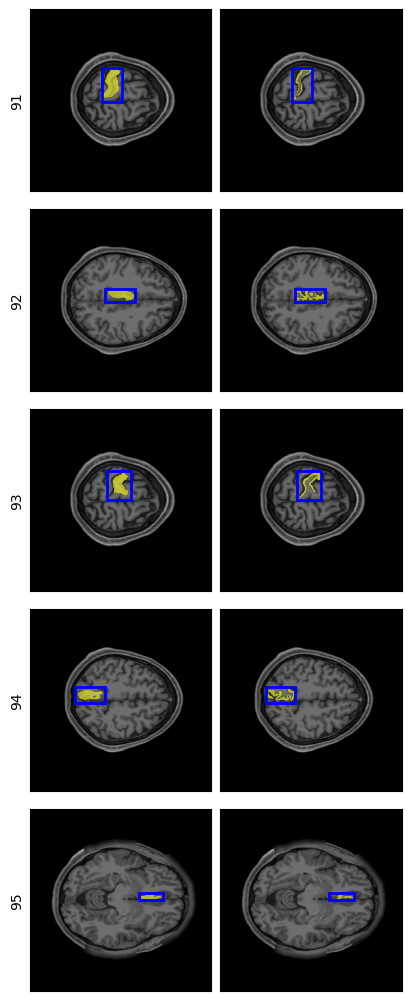

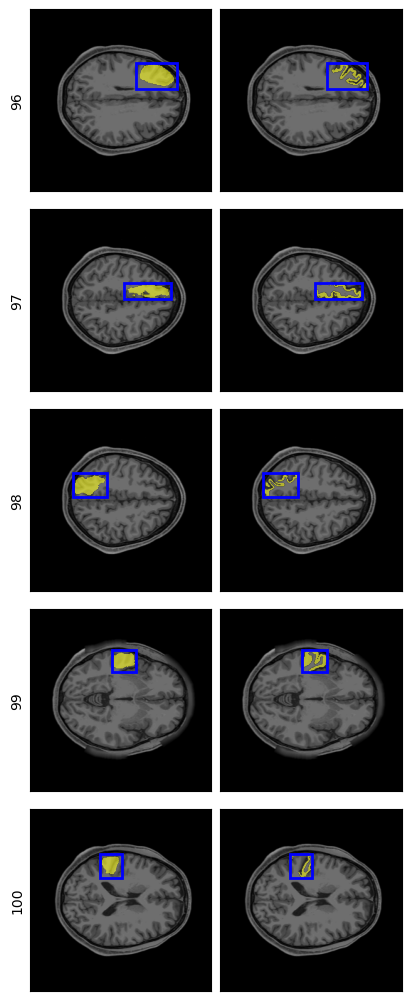

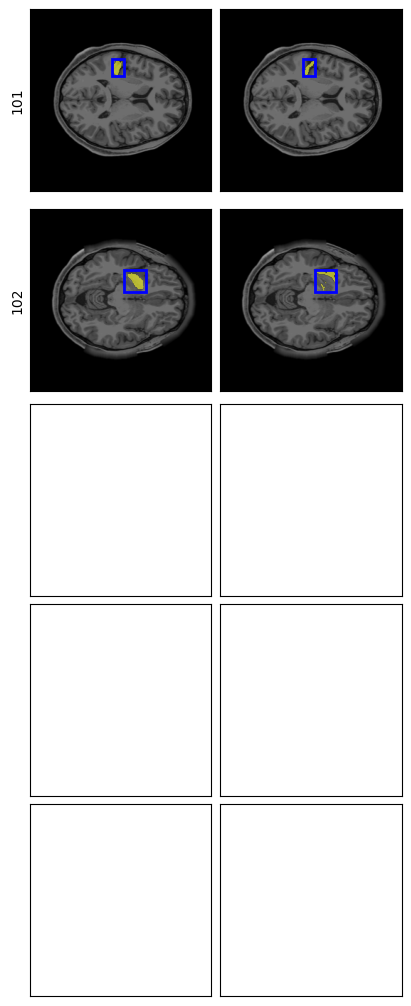

In [ ]:
r=5
c=2

for st in range(1, 103, r):
    fig, axs = plt.subplots(r,c, squeeze=False, figsize=(4,10), constrained_layout=True)
    for i, label in enumerate(range(st, min(st+r, 103))):
        slice = plot_for_label(label, None, seg, axs[i,0])
        gt_seg = np.load(f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/{mri_id}/seg_{slice}.npy') # (256,256)
        
        gt_seg = label_converter.hcp_to_compressed(gt_seg) # (256,256)

        # one-hot encode to (103, 256, 256)
        one_hot_enc = np.zeros((103,256*256))

        gt_flattened = gt_seg.flatten() # 256*256
        one_hot_enc[gt_flattened, np.arange(len(gt_flattened))] = 1 # (103, 256*256)
        one_hot_enc = np.reshape(one_hot_enc, (103,256,256))

        plot_for_label(label, slice, one_hot_enc, axs[i,1])

        axs[i,0].set_ylabel(label)
    for i in range(r):
        for j in range(2):
            axs[i,j].grid(False)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([]) 
    
    fig.savefig(f'/gpfs/home/kn2347/figs/untuned_segmentations/{st}_to_{label}')